In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect # detect text language
from statsmodels.graphics.mosaicplot import mosaic # mosaic plots
import seaborn as sns
import textstat
from urlextract import URLExtract # to extract urls form the text

In [2]:
notes = pd.read_parquet('rated_notes_compact.parquet', engine='auto')

In [3]:
# clumn names
notes.columns

Index(['noteId', 'finalRatingStatus', 'firstTag', 'secondTag',
       'classification', 'createdAtMillis', 'numRatings', 'noteTopic',
       'topicNoteConfident', 'noteAuthorParticipantId', 'tweetId',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote'],
      dtype='object')

In [4]:
# change tweetId format to see the whole assigned number rather than scientific notation
notes['tweetId'] = notes['tweetId'].astype(int)

In [4]:
# number of rated notes
len(notes)

175861

check assigned topics

In [5]:
notes['noteTopic'].value_counts()

noteTopic
GazaConflict       9540
UkraineConflict    5970
MessiRonaldo        514
Name: count, dtype: int64

In [6]:
notes['noteTopic'].unique()

array([None, 'GazaConflict', 'UkraineConflict', 'MessiRonaldo'],
      dtype=object)

check how many does not have an assigned topic

In [7]:
len(notes[notes['noteTopic'].values == None])

159837

Most of them does not have an assigned topic! Let's see 10 random note without a topic!


In [8]:
notes[notes['noteTopic'].values == None]['summary'].sample(n=10)

159790    Misinformation!  The police have clarified tha...
151108    Esta cuenta no es la oficial que usan para Squ...
9981      Contrails are formed when water vapour and fin...
27500     The latest public release of MacOS is MacOS 14...
67707                                                  None
127393    Information trompeuse, aucune enquête du FBI e...
8123      This is completely made up. An article in the ...
17778     Grupo Bimbo ha dado a conocer que esta campaña...
122475    NNN    The original post didn’t mention when t...
58071     Your keyboard does not have this functionality...
Name: summary, dtype: object

It seems like most of them are not in English! Plus, some of them are None! Let's remove the None s and detect the language the notes were written in!

In [9]:
notes = notes[notes['summary'].notna()]

In [10]:
len(notes)

159226

In [11]:
# using detect function from langdetect to create a new column for languages
langs = []
for note in notes['summary']:
    try:
        langs.append(detect(note))
    # except LangDetectException:
    #     print(f"LangDetectException for note: {note}")
    #     langs.append(None)
    except Exception as error:
    # handle the exception
        print("An exception occurred:", error) 
        print(note)
        langs.append(None)

An exception occurred: No features in text.
🖕🖕🖕🖕🖕🖕
An exception occurred: No features in text.
http://www.shadowstats.com/alternate_data/inflation-charts
An exception occurred: No features in text.
🫡
An exception occurred: No features in text.
🔥 🐶☕ 🔥
An exception occurred: No features in text.
.
An exception occurred: No features in text.
https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/vaccine_pfizer_bivalent.html#002
An exception occurred: No features in text.
https://sites.imsa.edu/acronym/2021/03/04/elon-musk-is-not-an-entrepreneur-hes-a-rich-deceitful-hack/  https://www.cnbc.com/2018/06/01/elon-musks-mom-worked-5-jobs-to-raise-3-kids-after-her-divorce.html  https://www.cnbc.com/2018/06/12/telsas-elon-musk-tweets-he-arrived-in-north-america-at-17-with-2000.html  
An exception occurred: No features in text.
https://twitter.com/horacioneiva/status/1658638214385614852?s=20
An exception occurred: No features in text.
https://www.washingtonpost.com/politics/2021/03/19/how-spot-fake-vide

In [22]:
notes['language'] = langs
# update the saved dataframe
notes.to_parquet('rated_notes_compact.parquet')

There are some notes without a language. They may contain external links, emojis, numbers, punctuation marks or a mixture of them.

In [27]:
# How many of them contain non-language communications?
print(f"{sum(notes['language'].isnull())} \
notes did not use words; they used emojis, links, etc")

non_lang_notes = notes[notes['language'].isnull()]
print(f"{len(non_lang_notes[non_lang_notes['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL'])}\
 out of {len(non_lang_notes)} notes were rated helpful")


120 notes did not use words; they used emojis, links, etc
3 out of 120 notes were rated helpful


Seems like notes without further text does not help. Let's see the 3 helpfull ones!

In [28]:
non_lang_notes[non_lang_notes['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']['summary']

55399         https://www.britannica.com/event/World-War-II
83781          142 - 82 = 60    https://www.calculator.net/
174315    𝕋𝕙𝕚𝕤 𝕡𝕠𝕤𝕥 𝕔𝕠𝕟𝕥𝕒𝕚𝕟𝕤 𝕒𝕟 𝕦𝕟𝕕𝕚𝕤𝕔𝕝𝕠𝕤𝕖𝕕 𝕒𝕕 𝕗𝕠𝕣 𝕊𝕥𝕒𝕜𝕖...
Name: summary, dtype: object

One of them is actually an english notes which was wrongly identified as without language note.

In [30]:
print(f"There are notes from {notes['language'].nunique()} languages.")

There are notes from 47 languages.


In [11]:
# overall percentage of helpfulness
helpful_freq = len(notes[notes['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']) / len(notes)
print(f"{helpful_freq*100:.1f}% of the notes were rated helpful")

75.9% of the notes were rated helpful


Let's see the distribution of languages of the note with more than 1% of the total

<Axes: xlabel='language'>

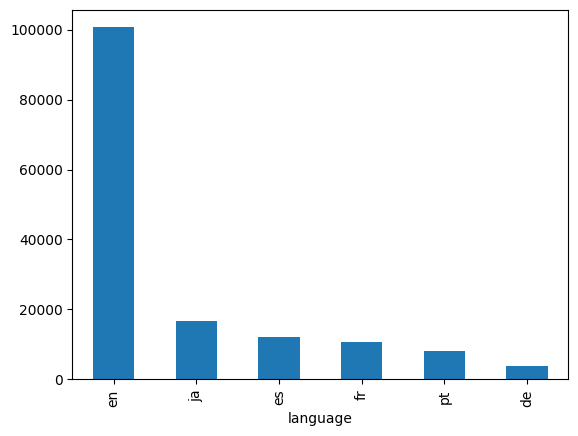

In [4]:
# notes['language'].hist()
# more popular languages 
pop_langs = notes['language'].value_counts()[notes['language'].value_counts() > .01*len(notes)].index

notes[notes['language'].isin(pop_langs)]['language'].value_counts().plot(kind='bar')

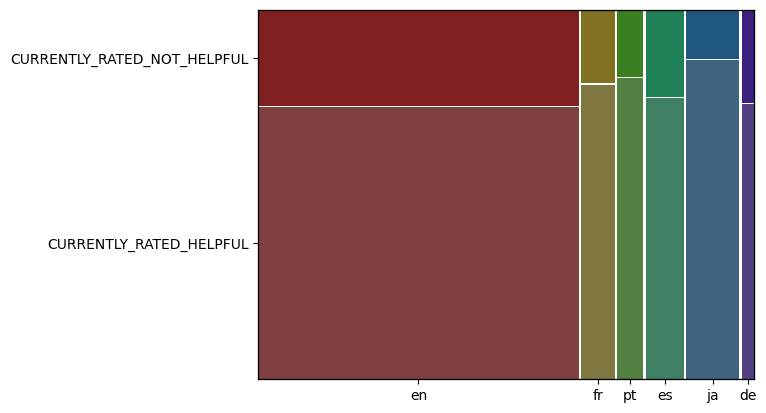

In [5]:
# compare labels of helpfulness between languages.
# plt.rcParams['font.size'] = 16 
mosaic(notes[notes['language'].isin(pop_langs)],
    ['language', 'finalRatingStatus'], labelizer=lambda k: '');

In [16]:
# The helpfulness level does not seem to be that different. Let's see!
helfulness_langs = notes[notes['language'].isin(pop_langs)] \
    .groupby(['language', 'finalRatingStatus']) \
    .count().reset_index()[['language', 'finalRatingStatus','noteId']]
# rename noteID
helfulness_langs.rename(columns={'noteId': 'count'}, inplace=True)

def percentage_lang(row):
    return (row['count'] / \
        helfulness_langs[helfulness_langs['language'] == row['language']]['count'].sum()
        * 100)
helfulness_langs['percent'] = helfulness_langs.apply(percentage_lang, axis=1)
helfulness_langs['above_average'] = helfulness_langs['percent'] > helpful_freq*100
helfulness_langs[helfulness_langs['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']



,language,finalRatingStatus,count,percent,above_average
0,de,CURRENTLY_RATED_HELPFUL,2870,74.778530,False
2,en,CURRENTLY_RATED_HELPFUL,74290,73.794104,False
4,es,CURRENTLY_RATED_HELPFUL,9187,76.386464,True
6,fr,CURRENTLY_RATED_HELPFUL,8479,79.975476,True
8,ja,CURRENTLY_RATED_HELPFUL,14440,86.711103,True
10,pt,CURRENTLY_RATED_HELPFUL,6596,81.694327,True


The majority of notes are in english. Let's focus on them.

In [42]:
df_eng = notes[notes['language'] == 'en']

Textstat package has multiple tests for reading grade or reading ease. However, the text_standard test is the mixture of all of them and seems to be the most accurate.
However, having a URL in the text fools textstat to give a much higher reading score.

In [37]:
text = df_eng.iloc[1]['summary']
print(f"Original text: {text}")
print(f"Reading score before removing urls: {textstat.text_standard(text, float_output=True)}")
extractor = URLExtract()
urls = extractor.find_urls(text)
print(f"Found URLs: {urls}")

# reomve urls from the text
for url in urls:
    text = text.replace(url, '')
print(f"Reading score after removing urls: {textstat.text_standard(text, float_output=True)}")

Original text: The headline in this photo does not appear on CNN.com.   https://www.google.com/search?q=intitle%3A%22jewish+hedge+fund%22+site%3Acnn.com
Reading score before removing urls: 38.0
Found URLs: ['CNN.com', 'https://www.google.com/search?q=intitle%3A%22jewish+hedge+fund%22+site%3Acnn.com']
Reading score after removing urls: 4.0


As a result, we need to create some more columns for keeping the characteristics of the note, after removing URLs and some other non-text characteristics (&quot, &amp)

In [44]:
# initiate some lists to keep new columns
noteClean = [] # keep the notes, potentialy for further analysis
hasURL = [] # if note contains url
nSentence = [] # number of sentences in the note
nWord = [] # number of words in the note
nSyllable = [] # number of syllables in the note
readingScore = [] # reading level given by text_standard from textstat package

# initiate url extractor
extractor = URLExtract()
# loop through the english dataframe to calculate each of the above variables
for idx, row in df_eng.iterrows():
    text = row['summary']
    hasURL.append(extractor.has_urls(text))
    # find urls
    urls = extractor.find_urls(text)
    # reomve urls from the text
    for url in urls:
        text = text.replace(url, '').replace('&quot', '').replace('&amp', '')
    noteClean.append(text)    
    nSentence.append(textstat.sentence_count(text))
    nWord.append(textstat.lexicon_count(text, removepunct=True))
    nSyllable.append(textstat.syllable_count(text))
    readingScore.append(textstat.text_standard(text, float_output=True))

df_eng = df_eng.assign(hasURL = hasURL,
                        noteClean = noteClean,
                        nSentence = nSentence,
                        nWord = nWord,
                        nSyllable = nSyllable,
                        readingScore = readingScore)
# save the dataframe
df_eng.to_parquet('notes_english.parquet')

In [6]:
# load english notes if not already loaded
df_eng = pd.read_parquet('notes_english.parquet', engine='auto')

In [45]:

# compare reading scores for helpful vs unhelpful notes
df_eng.groupby('finalRatingStatus')['readingScore'].mean()

finalRatingStatus
CURRENTLY_RATED_HELPFUL        9.165110
CURRENTLY_RATED_NOT_HELPFUL    8.421689
Name: readingScore, dtype: float64

They don't seem to be that different in reading score. Let's take a closer look at their distribution.

In [46]:
# first, distribution of reading scores
# sns.histplot(data=df_eng, x='readingScore')
df_eng['readingScore'].describe()

count    100672.000000
mean          8.970290
std           5.345574
min          -4.000000
25%           6.000000
50%           9.000000
75%          11.000000
max         340.000000
Name: readingScore, dtype: float64

There is a score of 300 among reading scores! Let's see what it is!

In [47]:
df_eng[df_eng['readingScore'] == max(df_eng['readingScore'])]['summary'].tolist()[0]

'情報源がいずれも個人のSNS投稿のみで正式な報道が無いため、デマの可能性が高いことに注意が必要です。    Google検索  https://www.google.com/search?q=%E3%83%AD%E3%83%83%E3%83%86+%E5%96%A7%E5%98%A9&amp;oq=%E3%83%AD%E3%83%83%E3%83%86%E3%80%80%E5%96%A7%E5%98%A9&amp;gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCDMwMzVqMGo0qAIAsAIB&amp;sourceid=chrome&amp;ie=UTF-8  https://www.google.com/search?q=%E3%83%AD%E3%83%83%E3%83%86+%E5%BF%83%E8%82%BA%E5%81%9C%E6%AD%A2&amp;sca_esv=f2c31ff271fb88b6&amp;sca_upv=1&amp;ei=jNC3ZuLkJJSYvr0Pr_TKmQQ&amp;oq=%E3%83%AD%E3%83%83%E3%83%86+%E5%BF%83%E8%82%BA&amp;gs_lp=Egxnd3Mtd2l6LXNlcnAiEOODreODg-ODhiDlv4PogroqAggAMgQQABgDMggQABiABBiiBDIIEAAYgAQYogQyCBAAGIAEGKIEMggQABiABBiiBDIIEAAYgAQYogRI4TNQ5ghY4CJwAXgAkAEAmAGqAaAB2AqqAQM0Lji4AQHIAQD4AQGYAgmgAq8HwgILEAAYsAMYBBgeGA_CAgsQABiABBiwAxiiBMICChAAGIAEGEMYigXCAhAQABiABBixAxhDGIMBGIoFwgILEAAYgAQYsQMYgwHCAggQABiABBixA8ICDhAAGIAEGLEDGIMBGIoFwgIGEAAYAxgEwgINEAAYgAQYsQMYgwEYBMICBxAAGIAEGATCAggQABgEGAgYHsICCBAAGAQYBRgewgIFECEYoAGYAwCIBgGQBgWSBwMyLjegB-8i&amp;sclient=gws-wiz-serp'

It seems like the note has a link (which is in english). Maybe we need to remove the links before detecting languages!

In [49]:
detect(df_eng[df_eng['readingScore'] == max(df_eng['readingScore'])]['noteClean'].tolist()[0])

'en'

But this doesn't seem to work on this specific note either. Because it was written without spaces between links. Let's just remove outliers from the notes with regard to note scores.

In [50]:
# tukey's criteria (1.5 iqr + q3)
Q1, Q3 = df_eng['readingScore'].quantile([.25, .75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
df_eng_trimmed = df_eng[(df_eng['readingScore'] > lower_bound) &
                        (df_eng['readingScore'] < upper_bound)]

In [54]:
f"Percentage of outliers: {(len(df_eng) - len(df_eng_trimmed)) / len(df_eng)*100:.1f}"

'Percentage of outliers: 2.5'

<Axes: xlabel='readingScore', ylabel='Count'>

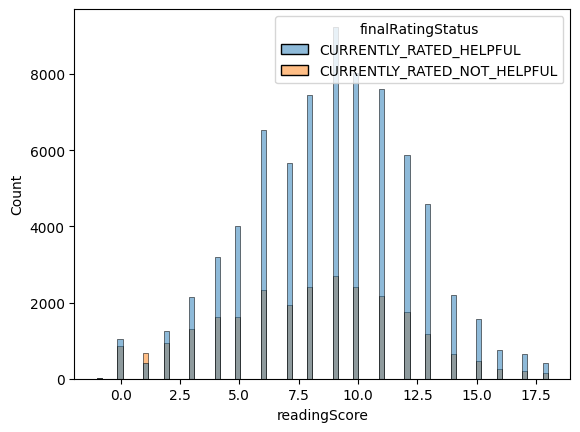

In [56]:
sns.histplot(data=df_eng_trimmed, x='readingScore', hue='finalRatingStatus')
#TODO look at the distribution of reading scores